<a href="https://colab.research.google.com/github/abuchin/transformer_immune/blob/main/transformer_immune_cells_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-tuning Geneformer for Allen Institutue Immune dataset**

The aim of this Notebook is to use pre-trained transformer models (Geneformer, scGPT) to fine-tune on immune cells derived from Allen Institute Immune atalas (https://apps.allenimmunology.org/aifi/resources/imm-health-atlas/downloads/scrna/). Initially we will fine-tune the model on monocytes.

This project has the following aims:

(i) Fine-tune existing foundational model on example cell-types (monocytes, NK, other cells), derived from different patients.

(ii) Learn the model to predict metadata like age based on data (gene expression profile). We will be predicting 3 groups of age: children, young adults and elderly.


**Install libraries**

In [1]:

!pip install torch
!pip install transformers
!pip install scanpy
!pip install datasets anndata

# Geneformer installation
!git lfs install
!git clone https://huggingface.co/ctheodoris/Geneformer
!pip install ./Geneformer

# install mygene
!pip install mygene

# install scvi
!pip install scvi-tools



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:

# save all requirements
!pip freeze > requirements.txt


## Import libraries

In [3]:

# get the standard libraries
import scanpy as sc
import pandas as pd
import numpy as np

import os
import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import json

# transformer libraries
from torch.utils.data import Dataset, random_split
import scvi
from tqdm.notebook import tqdm
from datasets import load_from_disk

# get the standard tokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification



In [4]:

# code to mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get the relevant data

In [5]:

# read adata: nk file
adata_nk=sc.read_h5ad('/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/human_immune_health_atlas_nk-ilc.h5ad')


In [6]:

# save raw data counts
adata_nk.X=adata_nk.raw.X

# keep origina counts in another layer
adata_nk.layers['counts']=adata_nk.raw.X


### Normalize the original data

In [7]:

# normalize and log-transform the data
sc.pp.normalize_total(adata_nk, target_sum=1e6)
sc.pp.log1p(adata_nk)  # log-transform


adata.X seems to be already log-transformed.


##Exploratory data analysis

In this part of the notebook we will explore the dataset from Allen Institute and check the amount of variables it has. Plot the UMAP plots and see how metadata is related to low-dimensional data representations.

In [8]:

# Step 1: Setup AnnData for scVI
adata_scvi = adata_nk.copy()  # make a separate copy to not modify the original
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key='subject.ageGroup')

# normalize
sc.pp.normalize_total(adata_scvi, target_sum=1e6)
sc.pp.log1p(adata_scvi)  # log-transform

# use 2K highly variable genes
sc.pp.highly_variable_genes(adata_scvi, n_top_genes=2000)


adata.X seems to be already log-transformed.


In [9]:

# Step 2: Train scVI model
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi.train(max_epochs=10)

# Step 3: Extract latent representation
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

# Step 4: Run neighbors and UMAP using the latent space
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:

# Step 3: Extract latent representation
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

# Step 4: Run neighbors and UMAP using the latent space
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)


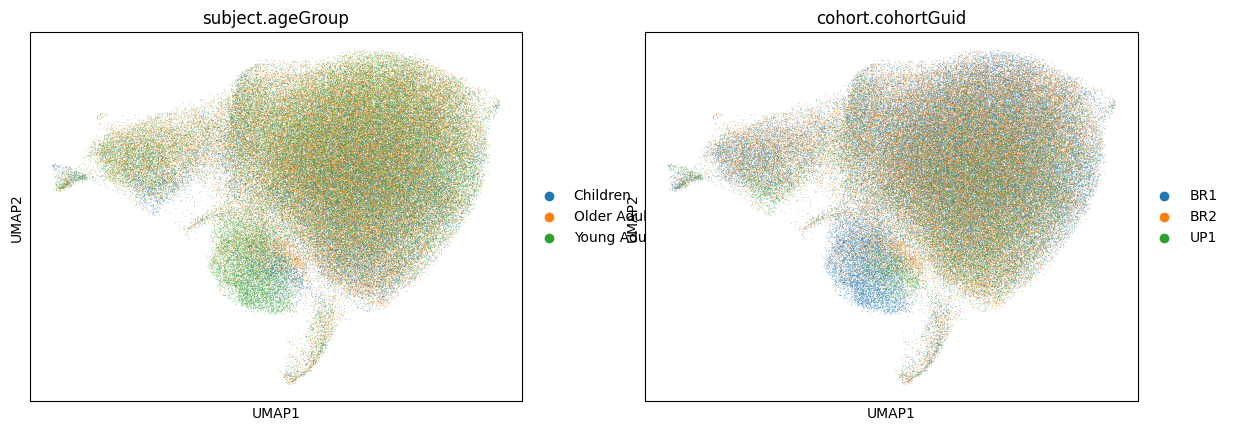

In [12]:

# show age group
sc.pl.umap(adata_scvi, color=['subject.ageGroup','cohort.cohortGuid'])


##Model fine-tuning

In this part we will use pre-trained Geneformer model from Hugging-Face (https://huggingface.co/ctheodoris/Geneformer). Freeze model parameters, train the fine-tuning layers and predict metadata variable.

We will evaluate the  model for masking the input.

##Model evaluation

In this part we will use model evaluation to check how well our fine-tuned model could predict metadata variables. And how good is the model for masked sample generation. We will plot confusion matrix, regression variables and other parameters for the model.

In [13]:

# if GPU available - move to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Initialize Tokenizer and Datasets

Tokenization of data in memory

In [14]:

# Get the tokenizer
from geneformer.tokenizer import tokenize_cell
import numpy as np
from datasets import Dataset as HFDataset
import torch
from geneformer.tokenizer import TranscriptomeTokenizer
import mygene


In [15]:

# Get the list of gene symbols from your AnnData object
gene_symbols = adata_nk.var.index.tolist()

# Instantiate the MyGene.info client
mg = mygene.MyGeneInfo()

# Query for Ensembl IDs
# Specify species='mouse' if you are working with mouse data
gene_info = mg.querymany(gene_symbols,
                         scopes='symbol',
                         fields='ensembl.gene',
                         species='human',
                         as_dataframe=True)


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

In [16]:

# Step 0: Map genes to the right names

# Create a clean Series for mapping, dropping genes that were not found
ensembl_map = gene_info.reset_index().dropna(subset=['ensembl.gene'])

# Create a dictionary for mapping from symbol ('query') to Ensembl ID
id_map = pd.Series(ensembl_map['ensembl.gene'].values, index=ensembl_map['query']).to_dict()

# Add the new 'ensembl_id' column to adata.var
adata_nk.var['ensembl_id'] = adata_nk.var.index.map(id_map)

# Display the result to verify
print(adata_nk.var.head())


              mito  n_cells_by_counts  mean_counts  log1p_mean_counts  \
MIR1302-2HG  False                 13     0.000006           0.000006   
FAM138A      False                  3     0.000001           0.000001   
OR4F5        False                 12     0.000006           0.000006   
AL627309.1   False               4433     0.002170           0.002167   
AL627309.3   False                496     0.000240           0.000240   

             pct_dropout_by_counts  total_counts  log1p_total_counts  \
MIR1302-2HG              99.999371            13            2.639057   
FAM138A                  99.999855             3            1.386294   
OR4F5                    99.999419            12            2.564949   
AL627309.1               99.785345          4481            8.407825   
AL627309.3               99.975983           496            6.208590   

                  ensembl_id  
MIR1302-2HG  ENSG00000243485  
FAM138A      ENSG00000237613  
OR4F5        ENSG00000186092  
AL62

### Data pre-processing

Remove genes without stable ENSID representation.

In [17]:

# keep original gene names
adata_nk.var['gene_name_HGCN'] = adata_nk.var.index.values

# convert cells to ensemble IDs
adata_nk.var['gene_name'] = adata_nk.var['ensembl_id']

# convert to ENSIDs
adata_nk.var_names=adata_nk.var['ensembl_id']


In [18]:

# make ENS ids the main names
valid_var_mask = pd.notnull(adata_nk.var_names)

# subset adata to these values
adata_nk = adata_nk[:, valid_var_mask]


## Tokenize the gene data

In [19]:

# Step 2: initialize
tk = TranscriptomeTokenizer()  # init with defaults
gene_token_dict = tk.gene_token_dict  # maps Ensembl ID → token index

# create genes and gene tokens
genes = adata_nk.var_names.to_list()
gene_tokens = np.array([gene_token_dict.get(g, 0) for g in genes], dtype=int)


In [20]:

# Step 3: align adata
# adata_nk.var_names should be Ensembl IDs
genes = adata_nk.var_names.to_list()
gene_tokens = np.array([gene_token_dict.get(g, 0) for g in genes], dtype=int)


### Speed-up: keep compute only to HVG

To spee things up we will be using only highly variable genes. Otherwise it takes way too long.

In [21]:

# cut this to only highly variable genes: 2K features
sc.pp.highly_variable_genes(adata_nk, n_top_genes=2000, inplace=True)

# subset the adata to only HVG
adata_nk = adata_nk[:, adata_nk.var.highly_variable].copy()


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:705: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


### Creating simple model to decode age

In this part we will create a simple classical ML model to classify age based on gene expression pattern. It would serve as a useful comparison to more complex models, like Geneformer that we will use for similar problem.

(i) We will first split the dataset

(ii) Train the model on gene expression data

(iii) Evaluate the model performance

This would allow us to see how well the model is performing for prediction of the age group. This would provide use with the baseline to see how much information we could extract from gene expression to predict age group.

In [22]:

# prepare the data for RF model training
X_rf=adata_nk.X.toarray()

# create random data splits
from sklearn.model_selection import train_test_split

# Stratified data split by age group
X_train, X_test, y_train, y_test = train_test_split(X_rf, adata_nk.obs['subject.ageGroup'],
                                              stratify=adata_nk.obs['subject.ageGroup'],
                                              test_size=0.2, random_state=42)


In [23]:

# Train Random forest model and evaluate on X_test
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model and print the classificatio report
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

    Children       0.92      0.12      0.21      4321
 Older Adult       0.56      0.55      0.55     12003
 Young Adult       0.58      0.75      0.65     13397

    accuracy                           0.58     29721
   macro avg       0.69      0.47      0.47     29721
weighted avg       0.62      0.58      0.55     29721



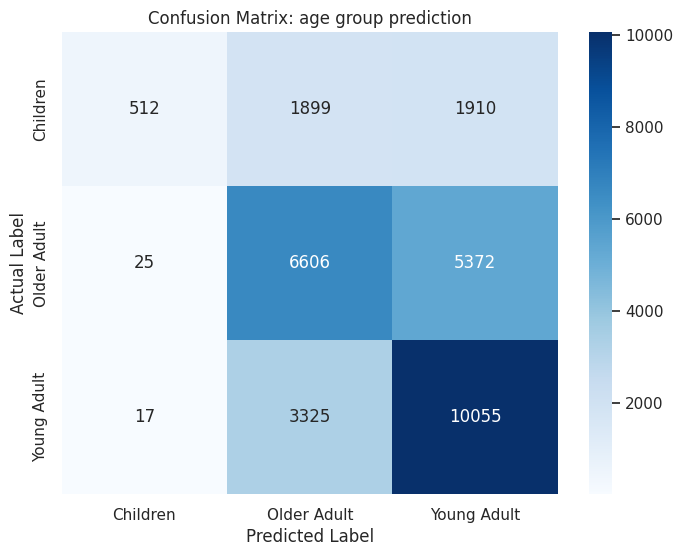

In [24]:

# Predict on the test set
y_pred = rf_model.predict(X_test)

# show the contingency matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# 1. Get class labels from the model
# Using rf_model.classes_ ensures the labels match the matrix order.
class_labels = rf_model.classes_

# 2. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# 3. Plot the heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

# Add title and axis labels for clarity
plt.title('Confusion Matrix: age group prediction')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

As we could see the information about the age group is present in gene expression profile of NK_cells, which means we could use it down-stream for Geneformer predictions.

### Save HVG data (not tokenized yet)

In [25]:

# adata file
adata_nk.write_h5ad("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/adata_nk_hvg.h5ad")

# save genes and tokens
np.save("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/genes.npy", genes)
np.save("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/gene_tokens.npy", gene_tokens)


### Save tokenized data

In this step we will form parallel implementaiton for tokenized data. All genes will be tokenized using this approach.

In [26]:

# Parallel implementation
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import numpy as np

# max token length
MAX_LEN = 512

# prepare labels once if available
if "subject.ageGroup" in adata_nk.obs.columns:
    labels_array = adata_nk.obs["subject.ageGroup"].astype("category").cat.codes.values
else:
    labels_array = None

def tokenize_cell(gene_vector, gene_tokens, return_indices=False):
    # Get indices sorted by descending expression
    nonzero_idx = np.where(gene_vector > 0)[0]
    sorted_idx = nonzero_idx[np.argsort(gene_vector[nonzero_idx])[::-1]]  # descending order

    # Get token IDs
    token_ids = [gene_tokens[i] for i in sorted_idx if i in gene_tokens]

    if return_indices:
        return token_ids, sorted_idx
    else:
        return token_ids

# define the per-cell processing function
def process_cell(idx):
    gene_vector = adata_nk.X[idx].toarray().flatten() if hasattr(adata_nk.X[idx], "toarray") else adata_nk.X[idx]

    # Step 1: Get token IDs and ranked indices
    # Assume tokenize_cell returns both ranked token IDs and their corresponding gene indices
    ranked_tokens, ranked_gene_indices = tokenize_cell(gene_vector, gene_tokens, return_indices=True)

    # Step 2: Slice and pad token IDs
    input_ids = list(ranked_tokens[:MAX_LEN])
    input_ids += [0] * (MAX_LEN - len(input_ids))

    attention_mask = [1 if id != 0 else 0 for id in input_ids]

    # Step 3: Slice and pad gene expression values
    gene_expr = list(gene_vector[ranked_gene_indices[:MAX_LEN]])
    gene_expr += [0.0] * (MAX_LEN - len(gene_expr))

    rec = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "gene_expr": gene_expr
    }

    if labels_array is not None:
        rec["labels"] = int(labels_array[idx])

    return rec

# parallel execution: adjust n_jobs based on available CPU



In [ ]:

# run tokenization using parallel execution
records = Parallel(n_jobs=4)(
    delayed(process_cell)(i) for i in tqdm(range(adata_nk.shape[0]), desc="Tokenizing cells (parallel)")
)


Tokenizing cells (parallel):   0%|          | 0/148605 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Save pre-processed tokenized data

### Create HF dataset

In [ ]:

# Step 5: build HF dataset
hf_ds = HFDataset.from_list(records)


In [ ]:

# save to disk
hf_ds.save_to_disk("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/tokenized_adata_nk")


### Reload the tokenized dataset

In [33]:

# save to disk
hf_ds = load_from_disk("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/tokenized_adata_nk")


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
